Deep Learning How to Fit a ball-stick Model to HCP diffusion MRI data

This is an adaptation of the original notebook describing the IVIM fitting approach proposed in "Deep Learning How to Fit an Intravoxel Incoherent Motion Model to Diffusion-Weighted MRI" by Barbieri et al., 2019. A preprint of the paper can be found at: https://arxiv.org/abs/1903.00095

Note that I wrote this code quickly without much care so there's probably some bugs!

Authors: Paddy Slator, Jason Lim, UCL.
p.slator@ucl.ac.uk


In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
# import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import torch.nn.functional as F
import math

/Users/paddyslator/python/self-qmri/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cart2mu(xyz):
    shape = xyz.shape[:-1]
    mu = np.zeros(np.r_[shape, 2])
    r = np.linalg.norm(xyz, axis=-1)
    mu[..., 0] = np.arccos(xyz[..., 2] / r)  # theta
    mu[..., 1] = np.arctan2(xyz[..., 1], xyz[..., 0])
    mu[r == 0] = 0, 0
    return mu


In [3]:
#datadir = '/Users/paddyslator/ibm-aspera-connect-downloads/data1/103818/T1w/Diffusion/'

#datadir = '/Users/paddyslator/ibm-aspera-connect-downloads/data1/114823/T1w/Diffusion/'

datadir = '/Users/paddyslator/Library/CloudStorage/OneDrive-UniversityCollegeLondon/data/HCP/111312_1/T1w/Diffusion/'

#datadir = '../Connecthon_WAND/charmed_train/derivatives/dwi/sub-06400/'



In [4]:
#bvals = np.loadtxt(datadir + "314_06400_CHARMED_2.bval")
#bvecs = np.loadtxt(datadir + "bvec.eddy_rotated_bvec")

bvals = np.loadtxt(datadir + "bvals")
bvecs = np.loadtxt(datadir + "bvecs")

#convert to microns^2/ms
bvals = bvals * 1e-03
#
bvecs = np.transpose(bvecs)





In [5]:
np.unique(bvals)

array([0.005, 0.99 , 0.995, 1.   , 1.005, 1.985, 1.99 , 1.995, 2.   ,
       2.005, 2.01 , 2.98 , 2.985, 2.99 , 2.995, 3.   , 3.005, 3.01 ])

In [6]:
print(np.shape(bvals[:,None]))
print(np.shape(bvecs))

grad = np.concatenate((bvecs,bvals[:,None]),axis=1)

(288, 1)
(288, 3)


In [7]:
np.shape(grad[:,0:3])

(288, 3)

In [8]:
#define the torch models on their own?

__all__ = [
    'ball_stick'
]


def ball_stick(grad,params):
    # extract the parameters
    f = params[:,0].unsqueeze(1)
    Dpar = params[:, 1].unsqueeze(1)
    Diso = params[:, 2].unsqueeze(1)
    theta = params[:, 3].unsqueeze(1)
    phi = params[:, 4].unsqueeze(1)    
    
    g = grad[:,0:2]
    bvals = grad[:,3]

    E = f * stick(grad, Dpar, theta, phi) + (1 - f) * ball(grad, Diso)

    return E


def ball(grad, Diso):
    bvals = grad[:, 3]

    E = torch.exp(-bvals * Diso)
    return E


def stick(grad, Dpar, theta, phi):
    g = grad[:, 0:2]
    bvals = grad[:, 3]

    n = sphere2cart(theta, phi)
          
    print(np.shape(bvals * Dpar))
    print(n)
    
    E = torch.exp(-bvals * Dpar * torch.mm(g, n) ** 2)
    return E

def sphere2cart(theta,phi):   
    n = torch.zeros(3,theta.size(0))
        
    n[0,:] = torch.squeeze(torch.sin(theta) * torch.cos(phi))
    n[1,:] = torch.squeeze(torch.sin(theta) * torch.sin(phi))
    n[2,:] = torch.squeeze(torch.cos(theta))   

In [9]:
#paramstor = torch.tensor([[0.5, 1, 2, 0.2, 0.3],[0.2, 2, 2, 0, 2]])
#gradtor = torch.tensor(grad)

#ball_stick(gradtor, paramstor)

In [10]:
# #jump straight in and define the neural network!

# class Net(nn.Module):
#     def __init__(self, gradient_directions_no0, b_values_no0, nparams):
#         super(Net, self).__init__()
#         #add grad directions, bvals
#         self.gradient_directions_no0 = gradient_directions_no0
#         self.b_values_no0 = b_values_no0
#         self.fc_layers = nn.ModuleList()
#         for i in range(3): # 3 fully connected hidden layers
#             self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ReLU()])
#         self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), nparams))
#         #self.dropout = nn.Dropout(0.5)

#     def forward(self, X):
        
#         #X = self.dropout(X)
        
#         params = torch.abs(self.encoder(X)) 

# #         t1_ball = params[:, 0].unsqueeze(1)
# #         t1_stick = params[:, 1].unsqueeze(1)
# #         lambda_par = params[:, 2].unsqueeze(1)
# #         lambda_iso = params[:, 3].unsqueeze(1)
# #         Fp = params[:,6].unsqueeze(1)
# #         theta = params[:,4].unsqueeze(1)
# #         phi = params[:,5].unsqueeze(1)

#         D_par = torch.clamp(params[:, 0].unsqueeze(1), min=0.001, max=3)
#         D_iso = torch.clamp(params[:, 1].unsqueeze(1), min=0.001, max=3)
#         #Fp = torch.clamp(params[:,4].unsqueeze(1), min=0.001, max=1)
#         Fp = params[:,4].unsqueeze(1)
#         theta = params[:,2].unsqueeze(1)
#         phi = params[:,3].unsqueeze(1)
                
#         mu_cart = torch.zeros(3,X.size()[0])
#         sintheta = torch.sin(theta)
#         mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
#         mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
#         mu_cart[2,:] = torch.squeeze(torch.cos(theta))
#         X = Fp*torch.exp(-b_values_no0 * D_iso) + (1-Fp)*torch.exp(-b_values_no0 * D_par * torch.einsum("ij,jk->ki",gradient_directions_no0, mu_cart) ** 2)
#         return X, D_par, D_iso, mu_cart, Fp
    
    

In [11]:
#jump straight in and define the neural network!

#WRITE A WRAPPER FUNCTION MAKEMODEL 
#makemodel(grad,modelname,latent_dim,network)
#different network VERSIONS - NORMAL NETWORK, VAE, ETC

class VariationalNet(nn.Module):
    def __init__(self, gradient_directions_no0, b_values_no0, nparams, latent_dim):
        super(VariationalNet, self).__init__()
        #add grad directions, bvals
        self.gradient_directions_no0 = gradient_directions_no0
        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        
        self.mean = nn.Linear(latent_dim, latent_dim, bias=True)
        self.logvar = nn.Linear(latent_dim, latent_dim, bias=True)
        
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ReLU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), latent_dim))
        self.decoder = nn.Linear(latent_dim, nparams)
        #self.dropout = nn.Dropout(0.5)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, X):
        
        #X = self.dropout(X)
        
        
        output_latent = torch.abs(self.encoder(X)) 
        
        mu, logvar = self.mean(output_latent), self.logvar(output_latent)
        z = self.reparameterize(mu, logvar)
        params = self.decoder(z)
        params = F.softplus(params)
        
#         t1_ball = params[:, 0].unsqueeze(1)
#         t1_stick = params[:, 1].unsqueeze(1)
#         lambda_par = params[:, 2].unsqueeze(1)
#         lambda_iso = params[:, 3].unsqueeze(1)
#         Fp = params[:,6].unsqueeze(1)
#         theta = params[:,4].unsqueeze(1)
#         phi = params[:,5].unsqueeze(1)

        
        D = torch.clamp(params[:, 0].unsqueeze(1), min = 0.01, max = 5)
        K = torch.clamp(params[:, 1].unsqueeze(1), min= 0.001, max=3)
        
        #D = params[:, 0].unsqueeze(1)
        #K = params[:, 1].unsqueeze(1)
        #bvals = self.grad[:,3]
        #TE = self.grad[:,4]

        X = torch.exp(-self.b_values_no0*D + (self.b_values_no0**2 * D**2 * K / 6)) 
        #X = 
        # D_par = torch.clamp(params[:, 0].unsqueeze(1), min=0.001, max=3)
        # D_iso = torch.clamp(params[:, 1].unsqueeze(1), min=0.001, max=3)
        # #Fp = torch.clamp(params[:,4].unsqueeze(1), min=0.001, max=1)
        # Fp = params[:,4].unsqueeze(1)
        # theta = params[:,2].unsqueeze(1)
        # phi = params[:,3].unsqueeze(1)
                
        # mu_cart = torch.zeros(3,X.size()[0])
        # sintheta = torch.sin(theta)
        # mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
        # mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
        # mu_cart[2,:] = torch.squeeze(torch.cos(theta))
        # X = Fp*torch.exp(-b_values_no0 * D_iso) + (1-Fp)*torch.exp(-b_values_no0 * D_par * torch.einsum("ij,jk->ki",gradient_directions_no0, mu_cart) ** 2)
        return X, D, K, mu, logvar
    
    

In [12]:
# # Network
# nparams = 5
# b_values_no0 = torch.FloatTensor(bvals)
# gradient_directions_no0 = torch.FloatTensor(bvecs)
# net = Net(gradient_directions_no0, b_values_no0, nparams)

# # Loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr = 0.0001) 
# #optimizer = optim.SGD(net.parameters(), lr = 0.01) 

In [13]:
import nibabel as nib
#load in some data and try fitting!
#imgnii = nib.load(datadir + "314_06400_CHARMED_denoisedMPPCA_driftCo_TED_gibbsCorrSubVoxShift.nii.gz")
imgnii = nib.load(datadir + "data.nii.gz")

masknii = nib.load(datadir + "nodif_brain_mask.nii.gz")

img = imgnii.get_fdata()
mask = masknii.get_fdata()

In [14]:
#preprocess data
from utilities.preprocessing import direction_average

#take the spherical mean
grad = np.concatenate((bvecs,bvals[:,None]), axis=1)
img,grad = direction_average(img,grad)

In [15]:
#image in voxel format
nvoxtotal = np.prod(np.shape(img)[0:3])
nvol = np.shape(img)[3]

imgvox = np.reshape(img,(nvoxtotal,nvol))


In [16]:
#do a smaller mask for now
zslice = 75
masktmp = np.zeros(np.shape(mask))
masktmp[:,:,zslice] = mask[:,:,zslice]
mask = masktmp

#mask in voxel format
maskvox = np.reshape(mask,(nvoxtotal))

In [17]:
imgvoxtofit = imgvox[maskvox==1]

In [18]:
#normalise the data

#find the volumes to normalise by - max ti, b=0
normvol = np.where(grad[:,3]==min(grad[:,3]))

imgvoxtofitnorm = imgvoxtofit/(np.tile(np.mean(imgvoxtofit[:,normvol], axis=2),(1, nvol)))



In [19]:
# Network
def kld_loss(mu, logvar, mu_prior=0.0, var_prior=1.0):
    # Kl between two Gaussians:
    #print(mu.size())
    #print(logvar.size())
    #loss = -0.5 - logvar.mean() + math.log(var_prior) + (logvar.mean().exp() + (mu.mean() - mu_prior)**2) / (2*(var_prior)**2)
    loss = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss, logvar.mean(), mu.mean()

nparams = 4
latent_dim = 128
b_values_no0 = torch.FloatTensor(grad[:,3])
gradient_directions_no0 = torch.FloatTensor(grad[:,0:2])
net = VariationalNet(gradient_directions_no0, b_values_no0, nparams, latent_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001) 
#optimizer = optim.SGD(net.parameters(), lr = 0.01) 

In [20]:
#try on simulated data!
#simdata = np.load('tests/simulated_data_ball_stick.npy')

#simimgvoxtofitnorm = simdata.item()['simulated_signal']
#ground_truth_param_vec = simdata.item()['ground_truth_param_vec']

In [21]:
#create batch queues for real data
batch_size = 128
num_batches = len(imgvoxtofitnorm) // batch_size
# X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(torch.from_numpy(imgvoxtofitnorm.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)



In [22]:
# # Best loss
# best = 1e16
# num_bad_epochs = 0
# patience = 5

# # Train
# for epoch in range(1000): 
#     print("-----------------------------------------------------------------")
#     print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
#     net.train()
#     running_loss = 0.

#     for i, X_batch in enumerate(tqdm(trainloader), 0):
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         X_pred, D_par_pred, D_iso_pred, mu_pred, Fp_pred = net(X_batch)
#         loss = criterion(X_pred, X_batch)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
      
#     print("Loss: {}".format(running_loss))
#     # early stopping
#     if running_loss < best:
#         print("############### Saving good model ###############################")
#         final_model = net.state_dict()
#         best = running_loss
#         num_bad_epochs = 0
#     else:
#         num_bad_epochs = num_bad_epochs + 1
#         if num_bad_epochs == patience:
#             print("Done, best loss: {}".format(best))
#             break
# print("Done")
# # Restore best model
# net.load_state_dict(final_model)

In [23]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 20
total_epochs = 1000
alpha = 1e-4

# Train
for epoch in range(total_epochs): 
    alpha_current = alpha * epoch / total_epochs
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.
    running_mse = 0.
    running_kl = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, D_pred, K_pred, mu, logvar = net(X_batch)
        loss_kl, m, std = kld_loss(mu, logvar)
        loss_mse = criterion(X_pred, X_batch)
        loss = loss_mse + alpha_current*loss_kl.mean()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_mse += loss_mse.item()
        running_kl += loss_kl.item()
      
    print("Loss: {}, kl: {}, mse:{}, mu: {}, logvar:{}".format(running_loss / (i + 1), running_kl / (i+1), running_mse / (i+1), m, std))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|██████████| 74/74 [00:01<00:00, 64.92it/s]


Loss: 0.024392839206533658, kl: 364.69726067620354, mse:0.024392839206533658, mu: -0.25396034121513367, logvar:0.020013222470879555
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 78.57it/s]


Loss: 0.009892046023663637, kl: 1608.0597996067356, mse:0.009731240054542149, mu: -0.8332732319831848, logvar:0.04762818291783333
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 77.90it/s]


Loss: 0.005573241480600995, kl: 4634.1917724609375, mse:0.004646403107766968, mu: -1.1523330211639404, logvar:0.04648873209953308
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 83.98it/s]


Loss: 0.005520235891831485, kl: 4166.409912109375, mse:0.00427031285456709, mu: -0.9113929867744446, logvar:0.032765477895736694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 80.14it/s]


Loss: 0.005582358609457072, kl: 3085.786261481208, mse:0.004348044094906465, mu: -0.7057211399078369, logvar:0.02484465390443802
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 1


100%|██████████| 74/74 [00:00<00:00, 78.96it/s]


Loss: 0.00551513907487026, kl: 2346.8217460013725, mse:0.004341728176695068, mu: -0.5429784655570984, logvar:0.018820680677890778
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 78.67it/s]


Loss: 0.0054785248200484625, kl: 1866.599003972234, mse:0.004358565346715418, mu: -0.42281046509742737, logvar:0.014657735824584961
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 81.47it/s]


Loss: 0.005397175161822422, kl: 1544.4792414484798, mse:0.004316039707486493, mu: -0.3141009509563446, logvar:0.019727978855371475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 79.36it/s]


Loss: 0.005316757228905083, kl: 1317.1726329906567, mse:0.004263019091701387, mu: -0.24915097653865814, logvar:0.02229483425617218
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 83.76it/s]


Loss: 0.005336427491636494, kl: 1212.599867537215, mse:0.004245087690022145, mu: -0.20350006222724915, logvar:0.02124807983636856
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


100%|██████████| 74/74 [00:00<00:00, 77.89it/s]


Loss: 0.005304144267496225, kl: 1112.436450855152, mse:0.004191707813407521, mu: -0.17089685797691345, logvar:0.02335074543952942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 79.78it/s]


Loss: 0.005287861004723488, kl: 1035.1343458021008, mse:0.004149213222459563, mu: -0.15322351455688477, logvar:0.021229643374681473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 79.38it/s]


Loss: 0.005305644552651289, kl: 984.4406515585409, mse:0.004124315700972, mu: -0.1294262707233429, logvar:0.018948301672935486
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|██████████| 74/74 [00:00<00:00, 75.04it/s]


Loss: 0.005292921965765591, kl: 923.8353791108002, mse:0.004091935959090856, mu: -0.1139334887266159, logvar:0.022176576778292656
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 2


100%|██████████| 74/74 [00:00<00:00, 75.69it/s]


Loss: 0.005267816041973797, kl: 868.3928107184332, mse:0.0040520661435014494, mu: -0.09589604288339615, logvar:0.022657491266727448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 79.40it/s]


Loss: 0.005262391994128356, kl: 825.8714096481735, mse:0.004023584845551365, mu: -0.09755164384841919, logvar:0.01686467044055462
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 75.11it/s]


Loss: 0.005222106969135033, kl: 776.3426068280194, mse:0.003979958817236931, mu: -0.09171406924724579, logvar:0.011119781993329525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 82.58it/s]


Loss: 0.0051892104753721, kl: 738.1370057801943, mse:0.003934377577860613, mu: -0.07998280972242355, logvar:0.011337831616401672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 78.18it/s]


Loss: 0.005103746916771539, kl: 689.8794135016363, mse:0.0038619639723234483, mu: -0.07193359732627869, logvar:0.010317121632397175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 78.42it/s]


Loss: 0.005091318439037816, kl: 652.7791459367082, mse:0.0038510380954657857, mu: -0.07239095866680145, logvar:0.006291350815445185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 79.26it/s]


Loss: 0.005057285769490173, kl: 619.7979736328125, mse:0.003817689828448803, mu: -0.07068921625614166, logvar:0.0050772251561284065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 81.41it/s]


Loss: 0.005062605631915298, kl: 598.0853234368402, mse:0.0038066263801443414, mu: -0.06565389037132263, logvar:0.004142598249018192
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|██████████| 74/74 [00:00<00:00, 82.12it/s]


Loss: 0.0050732901137372525, kl: 576.9641039049303, mse:0.0038039691280573606, mu: -0.06458999216556549, logvar:0.0036691660061478615
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 2


100%|██████████| 74/74 [00:00<00:00, 82.40it/s]


Loss: 0.005066142763590088, kl: 552.9563276961043, mse:0.0037943432013176986, mu: -0.06463466584682465, logvar:0.003329463303089142
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 3


100%|██████████| 74/74 [00:00<00:00, 79.13it/s]


Loss: 0.005099535089086842, kl: 539.780955546611, mse:0.0038040607595010785, mu: -0.05838591977953911, logvar:0.0031883814372122288
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 4


100%|██████████| 74/74 [00:00<00:00, 79.48it/s]


Loss: 0.0051156918839173945, kl: 522.0294193577122, mse:0.0038106183559205886, mu: -0.062215421348810196, logvar:0.0025972616858780384
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 5


100%|██████████| 74/74 [00:00<00:00, 80.84it/s]


Loss: 0.005121532849640258, kl: 498.08893688305005, mse:0.003826501577891208, mu: -0.059696100652217865, logvar:0.0019664056599140167
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 6


100%|██████████| 74/74 [00:00<00:00, 79.28it/s]


Loss: 0.005117297855306517, kl: 482.09119477143156, mse:0.003815651619555177, mu: -0.056971002370119095, logvar:0.0017457574140280485
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 7


100%|██████████| 74/74 [00:00<00:00, 80.44it/s]


Loss: 0.005091901827679091, kl: 459.84034027924406, mse:0.0038043489000080407, mu: -0.051740869879722595, logvar:0.0017822673544287682
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 8


100%|██████████| 74/74 [00:00<00:00, 79.83it/s]


Loss: 0.005040184575812639, kl: 438.9314583443307, mse:0.0037672833375934816, mu: -0.047612227499485016, logvar:0.001113777980208397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 82.81it/s]


Loss: 0.004962233043074407, kl: 407.9277628305796, mse:0.0037384496787814677, mu: -0.044354408979415894, logvar:0.0014177673729136586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 79.73it/s]


Loss: 0.00483619372322652, kl: 386.26581882786104, mse:0.003638769668287824, mu: -0.04034328833222389, logvar:0.001528402091935277
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 78.47it/s]


Loss: 0.004778526997118181, kl: 366.6410303889094, mse:0.0036052756728856146, mu: -0.03675338998436928, logvar:0.0014036950888112187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 76.70it/s]


Loss: 0.004681509960367269, kl: 344.3560527079814, mse:0.003545135006346312, mu: -0.0324927493929863, logvar:0.0024768959265202284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 81.96it/s]


Loss: 0.004570812109631259, kl: 319.9040729419605, mse:0.0034831383271847626, mu: -0.02977561578154564, logvar:0.0013537210179492831
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 81.38it/s]


Loss: 0.004475324738745553, kl: 305.4966634801916, mse:0.0034060864142972875, mu: -0.028118517249822617, logvar:0.0012123287888243794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 79.66it/s]


Loss: 0.0044413959808849, kl: 294.36061013711463, mse:0.0033816977945231906, mu: -0.028732292354106903, logvar:0.0008783263619989157
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|██████████| 74/74 [00:01<00:00, 72.56it/s]


Loss: 0.00442530310435875, kl: 286.4419347402212, mse:0.003365467971102712, mu: -0.02924864925444126, logvar:0.0004518100176937878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 81.06it/s]


Loss: 0.0044183845386362155, kl: 279.3542142300992, mse:0.0033568384840052473, mu: -0.02813759073615074, logvar:0.0026003431994467974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|██████████| 74/74 [00:00<00:00, 79.95it/s]


Loss: 0.00442071897732849, kl: 270.7596551018792, mse:0.0033647563085085837, mu: -0.02870761789381504, logvar:0.0016027349047362804
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|██████████| 74/74 [00:00<00:00, 77.25it/s]


Loss: 0.004447705489960876, kl: 270.2506703557195, mse:0.0033667028230312908, mu: -0.028639083728194237, logvar:0.002694733440876007
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 2


100%|██████████| 74/74 [00:00<00:00, 79.20it/s]


Loss: 0.004462877492974135, kl: 267.60034488987276, mse:0.003365716104068466, mu: -0.028484731912612915, logvar:0.0007962470990605652
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 3


100%|██████████| 74/74 [00:00<00:00, 75.35it/s]


Loss: 0.004451975877698813, kl: 261.24777963999156, mse:0.0033547351722026594, mu: -0.02743200585246086, logvar:0.0006009457865729928
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 4


100%|██████████| 74/74 [00:00<00:00, 78.15it/s]


Loss: 0.004466953171366775, kl: 257.41977774130334, mse:0.0033600481283674773, mu: -0.0291990265250206, logvar:-2.679768658708781e-05
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 5


100%|██████████| 74/74 [00:00<00:00, 80.53it/s]


Loss: 0.004498562454623547, kl: 257.3017143043312, mse:0.0033664349671075674, mu: -0.02822466380894184, logvar:0.0011650281958281994
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 6


100%|██████████| 74/74 [00:00<00:00, 80.76it/s]


Loss: 0.004508099631985297, kl: 255.08306678565773, mse:0.003360225767136325, mu: -0.027378268539905548, logvar:0.002234955783933401
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 7


100%|██████████| 74/74 [00:00<00:00, 82.77it/s]


Loss: 0.004528263788292739, kl: 252.2177346719278, mse:0.003368062212610164, mu: -0.027992481365799904, logvar:0.0013207285664975643
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 8


100%|██████████| 74/74 [00:00<00:00, 79.33it/s]


Loss: 0.004547327351001267, kl: 248.6669620823216, mse:0.0033785926360586607, mu: -0.028447795659303665, logvar:0.0006395185482688248
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 9


100%|██████████| 74/74 [00:00<00:00, 83.83it/s]


Loss: 0.004580672959344009, kl: 248.95498677846547, mse:0.003385688955392185, mu: -0.028793001547455788, logvar:0.00011369763524271548
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 10


100%|██████████| 74/74 [00:00<00:00, 80.10it/s]


Loss: 0.004597556975519133, kl: 244.9450493889886, mse:0.0033973262321229116, mu: -0.027546433731913567, logvar:0.0010335559491068125
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 11


100%|██████████| 74/74 [00:00<00:00, 80.35it/s]


Loss: 0.004618798747558046, kl: 246.1341229000607, mse:0.003388128167874104, mu: -0.028380436822772026, logvar:-0.00044546465505845845
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 12


100%|██████████| 74/74 [00:00<00:00, 80.04it/s]


Loss: 0.004671537946607615, kl: 246.0085595620645, mse:0.003416894266469958, mu: -0.029060788452625275, logvar:-0.00020726000366266817
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 13


100%|██████████| 74/74 [00:00<00:00, 79.51it/s]


Loss: 0.00467592163791729, kl: 241.5133961857976, mse:0.0034200519628545924, mu: -0.02820567414164543, logvar:0.0004950185539200902
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 14


100%|██████████| 74/74 [00:01<00:00, 73.56it/s]


Loss: 0.004683441277970937, kl: 238.58894760544234, mse:0.003418919907228367, mu: -0.02823094092309475, logvar:-0.00018392856873106211
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 15


100%|██████████| 74/74 [00:00<00:00, 76.51it/s]


Loss: 0.004705358649025092, kl: 236.75633961445575, mse:0.0034268743522163176, mu: -0.02942451648414135, logvar:-0.0013947165571153164
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 16


100%|██████████| 74/74 [00:00<00:00, 77.07it/s]


Loss: 0.004739836899790208, kl: 235.7626767545133, mse:0.003443142196251633, mu: -0.02699485793709755, logvar:0.001634901505894959
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 17


100%|██████████| 74/74 [00:01<00:00, 73.18it/s]


Loss: 0.00477028580860713, kl: 236.2632858688767, mse:0.003447211457642953, mu: -0.02823466807603836, logvar:-9.09331429284066e-05
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 18


100%|██████████| 74/74 [00:00<00:00, 77.24it/s]


Loss: 0.004778687348211738, kl: 233.57460929252005, mse:0.003447311996431971, mu: -0.026604745537042618, logvar:0.0017031675670295954
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 19


100%|██████████| 74/74 [00:00<00:00, 80.53it/s]

Loss: 0.004805431002750993, kl: 233.97010040283203, mse:0.0034484044000556743, mu: -0.02723550610244274, logvar:0.0006052589742466807
Done, best loss: 0.32696045585907996
Done


<All keys matched successfully>

In [24]:
#estimate the real data para
# meters with the trained network 
net.eval()
with torch.no_grad():
    X_real_pred, D, K, _, __ = net(torch.from_numpy(imgvoxtofitnorm.astype(np.float32)))
    
X_real_pred = X_real_pred.numpy()
D = D.numpy()
K = K.numpy()

# mu_cart = mu_cart.numpy()
# Fp = Fp.numpy()

# mu_cart_transposed = mu_cart.transpose()
# mu_vals = cart2mu(mu_cart_transposed)
# theta = mu_vals[:,0]
# phi = mu_vals[:,1]

In [25]:
#if simulated compare to the training params!
# import matplotlib.pyplot as plt

# nparam = np.shape(ground_truth_param_vec)[1]

# fig, ax = plt.subplots(nparam-1, 1, figsize=(5,20))

# ax[0].plot(D_par,ground_truth_param_vec[:,2],'o',markersize=1)
# ax[1].plot(D_iso,ground_truth_param_vec[:,3],'o',markersize=1)
# ax[2].plot(Fp,ground_truth_param_vec[:,5],'o',markersize=1)
# ax[3].plot(theta,ground_truth_param_vec[:,0],'o',markersize=1)
# ax[4].plot(phi,ground_truth_param_vec[:,1],'o',markersize=1)


In [26]:
# plt.plot(bvals,imgvoxtofitnorm[1000,:],'x')
# plt.plot(bvals,X_real_pred[1000,:],'o')


In [27]:
from scipy import ndimage

D_vox = np.zeros(np.shape(maskvox))
D_vox[maskvox==1] = np.squeeze(D[:])
D_map = ndimage.rotate(np.reshape(D_vox,np.shape(mask)),90,reshape=False)

K_vox = np.zeros(np.shape(maskvox))
K_vox[maskvox==1] = np.squeeze(K[:])
K_map = ndimage.rotate(np.reshape(K_vox,np.shape(mask)),90,reshape=False)

# D_par_vox = np.zeros(np.shape(maskvox))
# D_par_vox[maskvox==1] = np.squeeze(D_par[:])
# D_par_map = ndimage.rotate(np.reshape(D_par_vox,np.shape(mask)),90,reshape=False)

# D_iso_vox = np.zeros(np.shape(maskvox))
# D_iso_vox[maskvox==1] = np.squeeze(D_iso[:])
# D_iso_map = ndimage.rotate(np.reshape(D_iso_vox,np.shape(mask)),90,reshape=False)

# theta_vox = np.zeros(np.shape(maskvox))
# theta_vox[maskvox==1] = np.squeeze(theta[:])
# theta_map = ndimage.rotate(np.reshape(theta_vox,np.shape(mask)),90,reshape=False)

# phi_vox = np.zeros(np.shape(maskvox))
# phi_vox[maskvox==1] = np.squeeze(phi[:])
# phi_map = ndimage.rotate(np.reshape(phi_vox,np.shape(mask)),90,reshape=False)

# Fp_vox = np.zeros(np.shape(maskvox))
# Fp_vox[maskvox==1] = np.squeeze(Fp[:])
# Fp_map = ndimage.rotate(np.reshape(Fp_vox,np.shape(mask)),90,reshape=False)

# mu_cart_vox = np.zeros((np.shape(maskvox)[0],3))
# mu_cart_vox[maskvox==1,:] = np.transpose(mu_cart[:])
# mu_cart_map = ndimage.rotate(np.reshape(mu_cart_vox,np.append(np.shape(mask),3)),90,reshape=False)



(-0.5, 173.5, 144.5, -0.5)

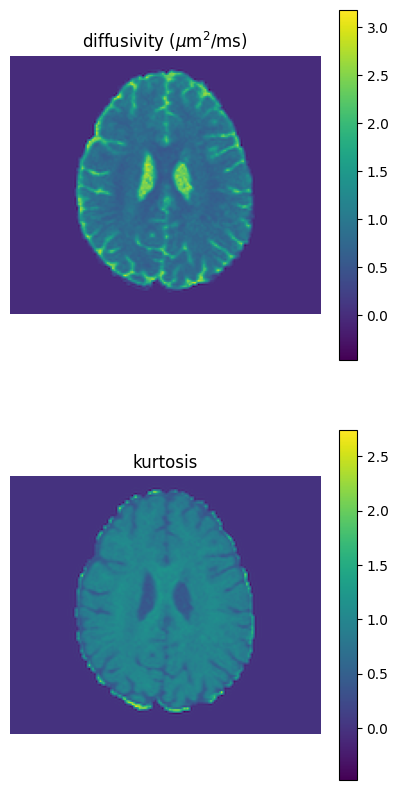

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(5,10))

plt0 = ax[0].imshow(D_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[0])
ax[0].xaxis.set_ticklabels([]) 
ax[0].set_title('diffusivity ($\mu$m$^2$/ms)')
ax[0].axis('off')

plt0 = ax[1].imshow(K_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[1])
ax[1].set_title('kurtosis')
ax[1].axis('off')

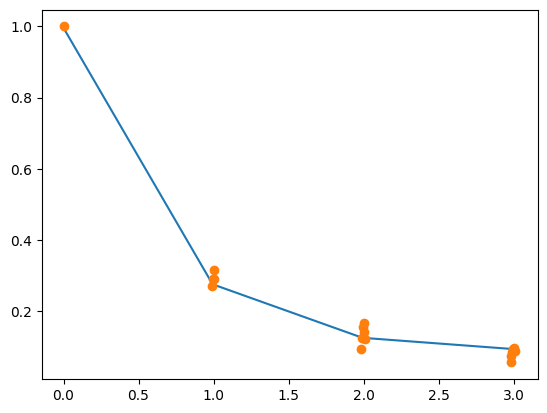

In [29]:
plt.plot(grad[:,3],X_real_pred[100,:])
plt.plot(grad[:,3],imgvoxtofitnorm[100,:],'o')

NameError: name 'D_par_map' is not defined

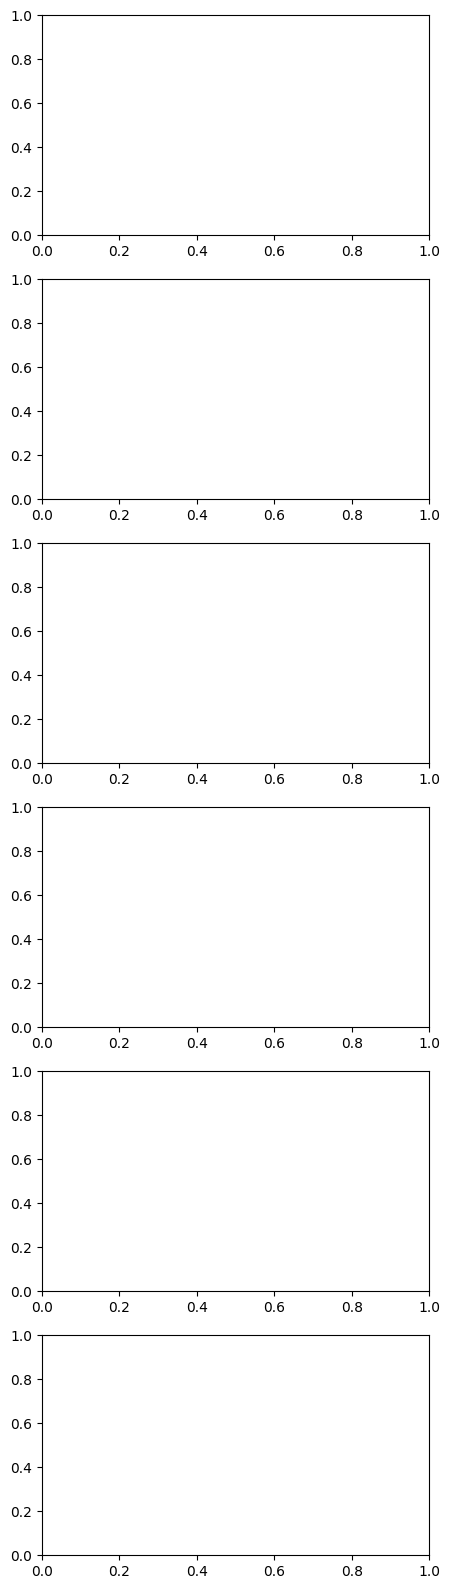

In [30]:
fig, ax = plt.subplots(6, 1, figsize=(5,20))

plt0 = ax[0].imshow(D_par_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[0])
ax[0].xaxis.set_ticklabels([]) 
ax[0].set_title('stick parallel diffusivity ($\mu$m$^2$/ms)')
ax[0].axis('off')

plt0 = ax[1].imshow(D_iso_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[1])
ax[1].set_title('ball isotropic diffusivity ($\mu$m$^2$/ms)')
ax[1].axis('off')

plt0 = ax[2].imshow(theta_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[2])
ax[2].set_title('theta')
ax[2].axis('off')

plt0 = ax[3].imshow(phi_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[3])
ax[3].set_title('phi')
ax[3].axis('off')

plt0 = ax[4].imshow(1-Fp_map[:,:,zslice],vmin=0,vmax=1)
plt.colorbar(plt0,ax=ax[4])
ax[4].set_title('stick volume fraction')
ax[4].axis('off')

plt0 = ax[5].imshow(np.abs((1-Fp_map[:,:,zslice:zslice+1]) * mu_cart_map[:,:,zslice,:]))
#plt0 = ax[5].imshow(np.abs(mu_cart_map[:,:,zslice,:]))
ax[5].set_title('DEC map')
ax[5].axis('off')


NameError: name 'D_par_map' is not defined

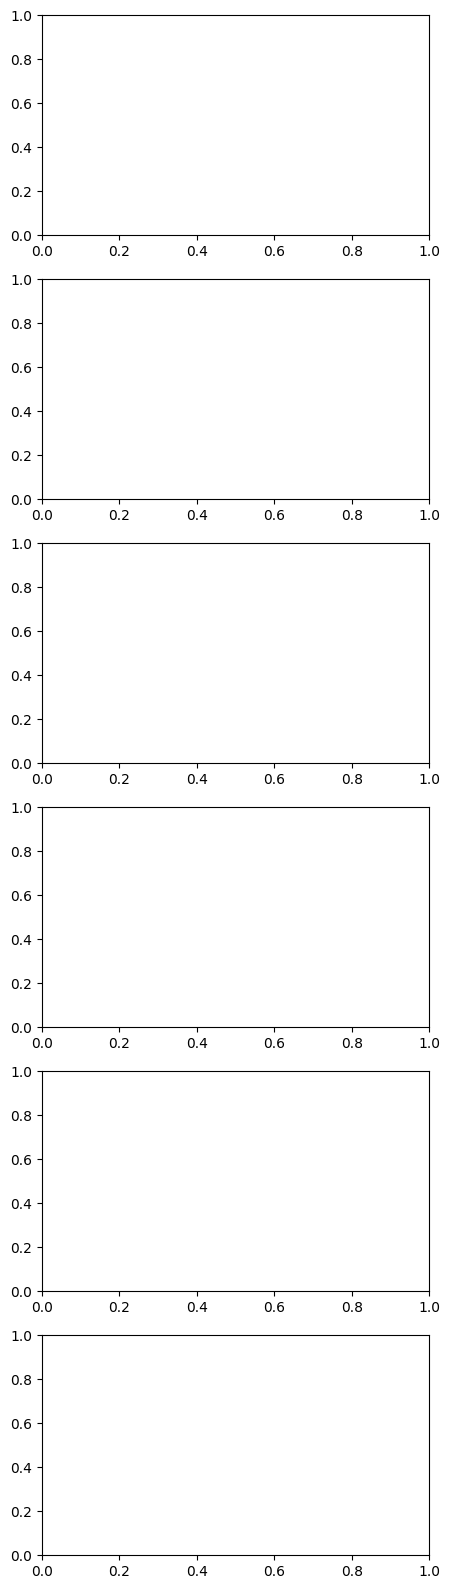

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(5,20))

plt0 = ax[0].imshow(D_par_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[0])
ax[0].xaxis.set_ticklabels([]) 
ax[0].set_title('stick parallel diffusivity ($\mu$m$^2$/ms)')
ax[0].axis('off')

plt0 = ax[1].imshow(D_iso_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[1])
ax[1].set_title('ball isotropic diffusivity ($\mu$m$^2$/ms)')
ax[1].axis('off')

plt0 = ax[2].imshow(theta_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[2])
ax[2].set_title('theta')
ax[2].axis('off')

plt0 = ax[3].imshow(phi_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[3])
ax[3].set_title('phi')
ax[3].axis('off')

plt0 = ax[4].imshow(1-Fp_map[:,:,zslice],vmin=0,vmax=1)
plt.colorbar(plt0,ax=ax[4])
ax[4].set_title('stick volume fraction')
ax[4].axis('off')

plt0 = ax[5].imshow(np.abs((1-Fp_map[:,:,zslice:zslice+1]) * mu_cart_map[:,:,zslice,:]))
#plt0 = ax[5].imshow(np.abs(mu_cart_map[:,:,zslice,:]))
ax[5].set_title('DEC map')
ax[5].axis('off')


In [ ]:
np.shape(np.tile(Fp_map[:,:,zslice],(3,1,1)))

(3, 110, 110)

In [ ]:
np.shape(np.abs(mu_cart_map[:,:,zslice,:]))

NameError: name 'mu_cart_map' is not defined

ValueError: x and y must have same first dimension, but have shapes (288,) and (18,)

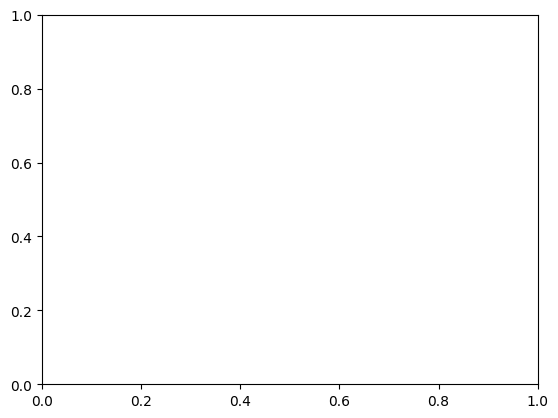

In [ ]:
plt.plot(bvals,imgvoxtofitnorm[100,:],'o')
plt.plot(bvals,X_real_pred[100,:],'x')

NameError: name 'mu_cart_map' is not defined

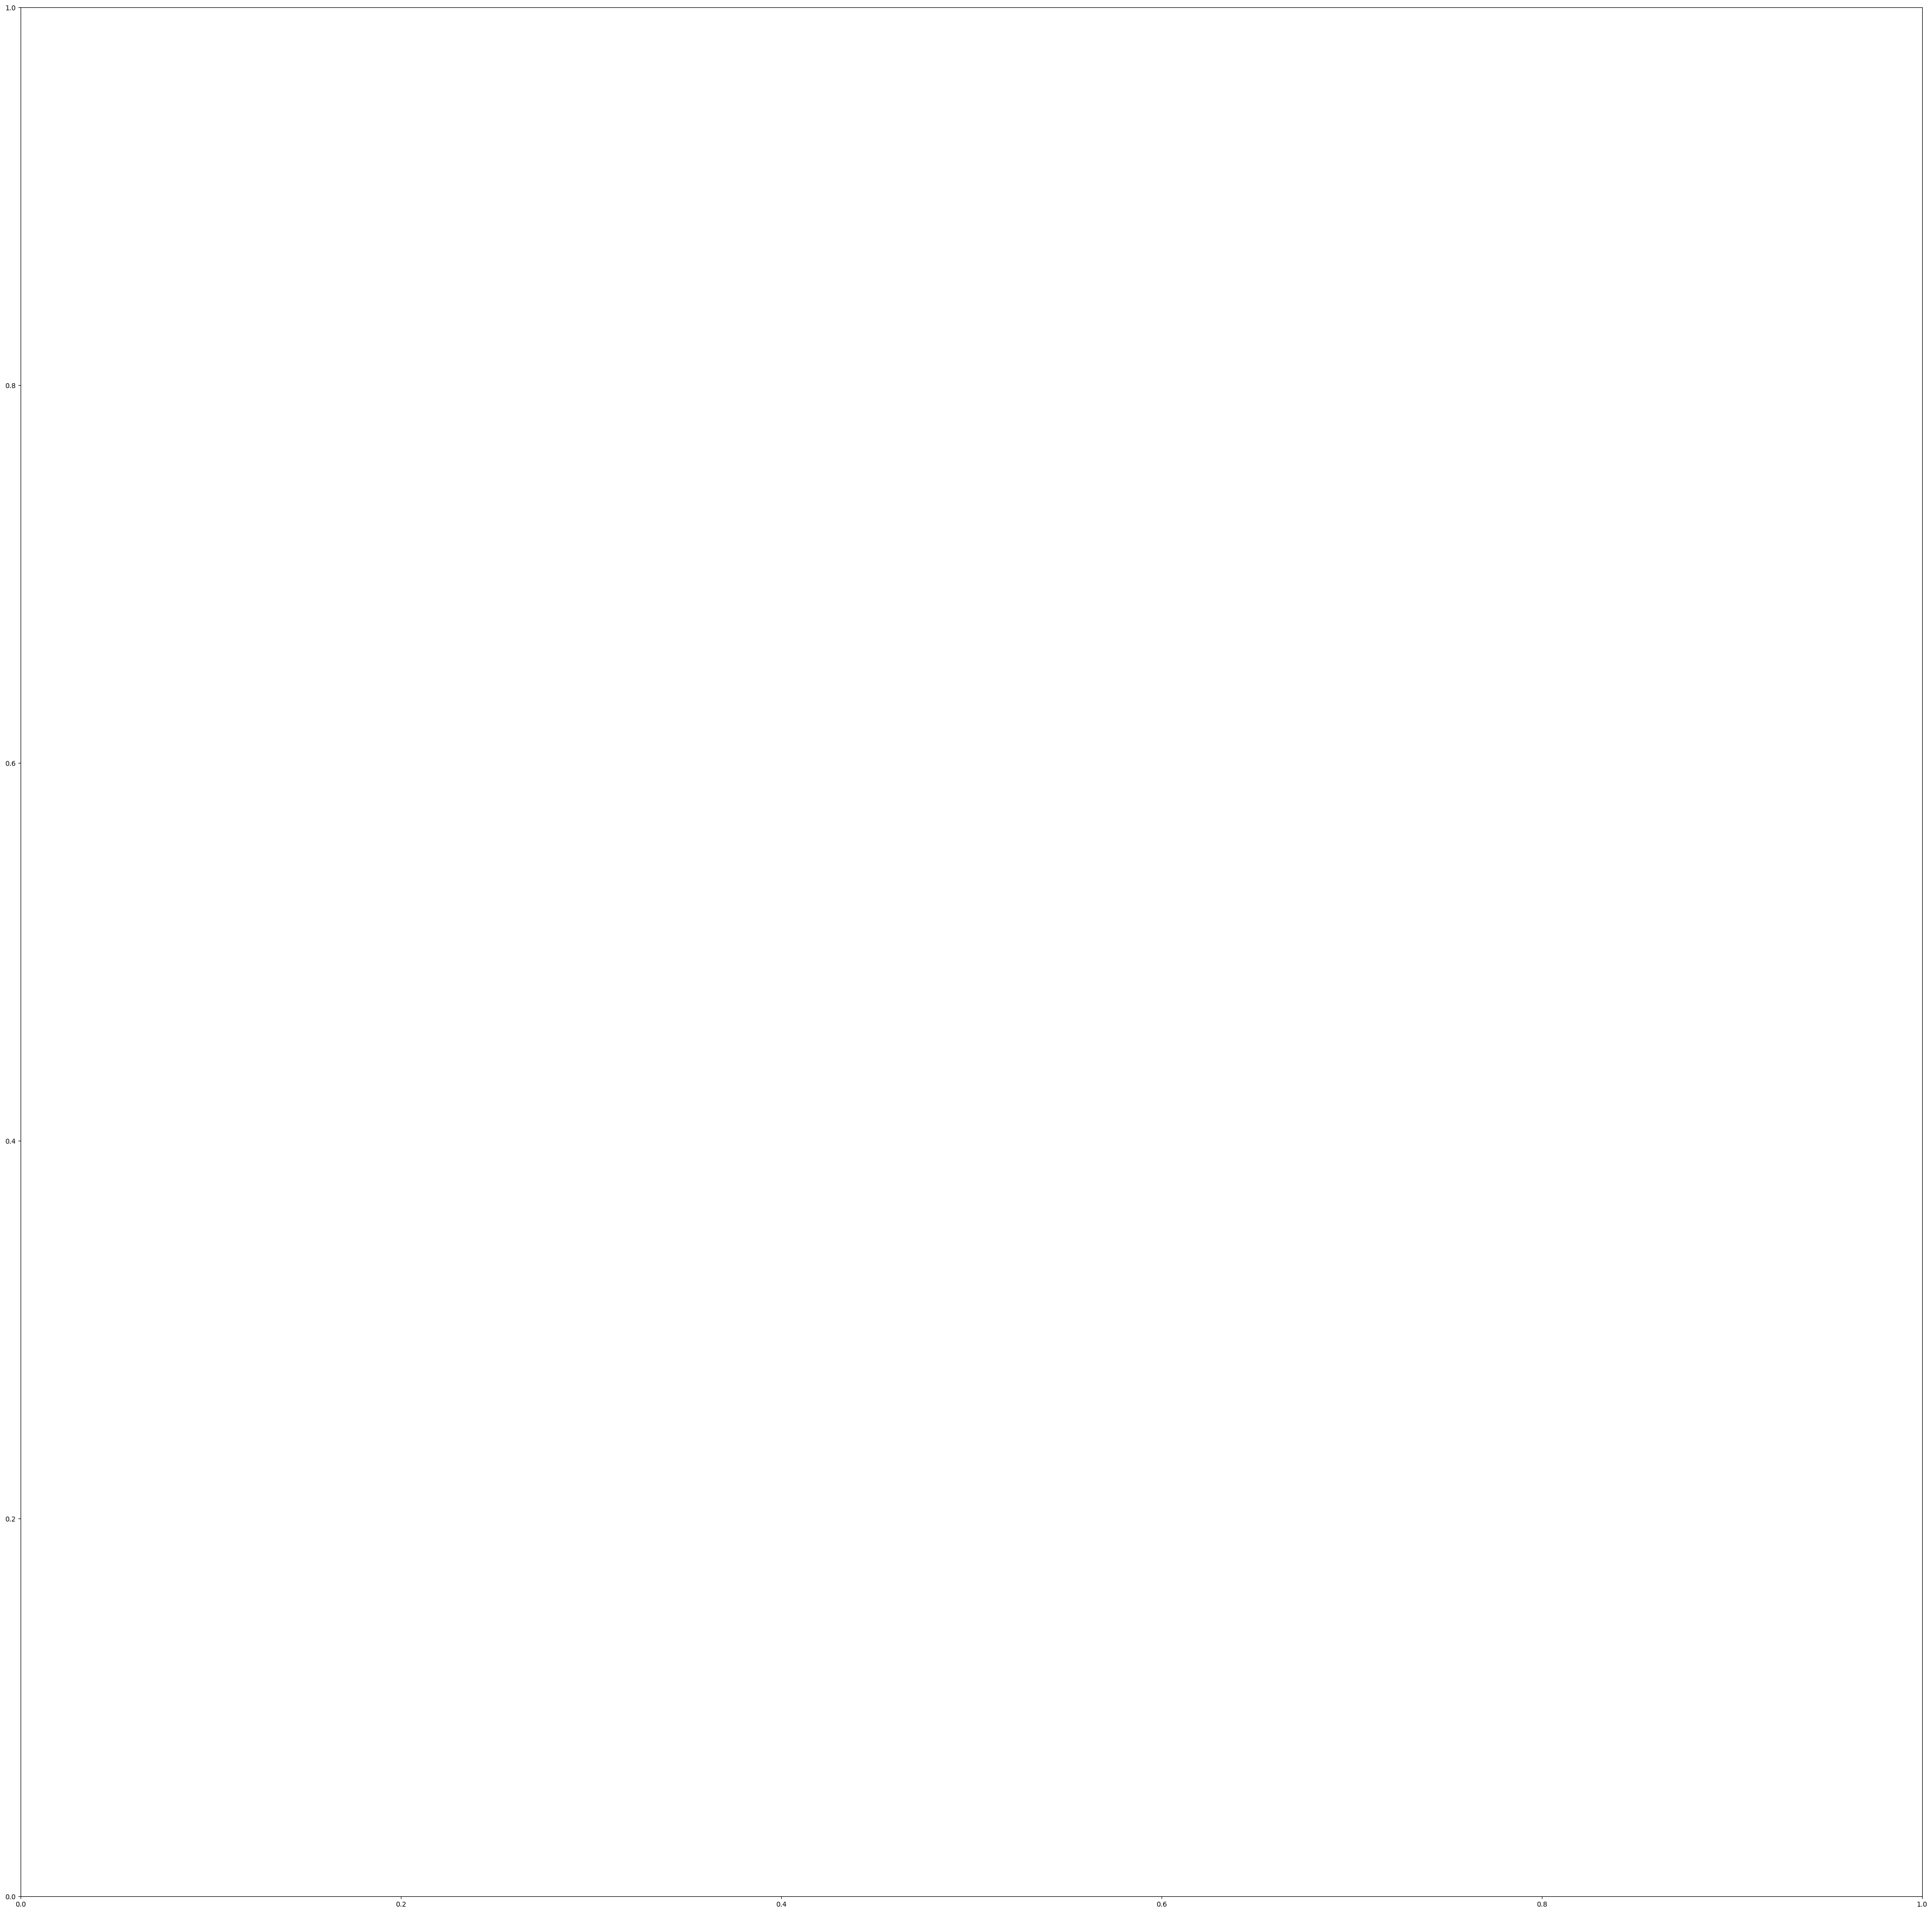

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(50,50))

x,y = np.meshgrid(np.linspace(0,np.shape(mu_cart_map)[1],np.shape(mu_cart_map)[1]), np.linspace(0,np.shape(mu_cart_map)[0],np.shape(mu_cart_map)[0]))

u = mu_cart_map[:,:,zslice,0]
v = mu_cart_map[:,:,zslice,1]

plt.quiver(x,y,u,v, headlength=0, headaxislength=0)
plt.show()


In [ ]:
from models import ball_stick

In [ ]:
plt.imshow(np.abs(mu_cart_map)[:,:,zslice,:])
plt.show()

In [ ]:
#MAKE THESE INTO BIG SIMULATED DATASETS! THEN TRAIN!
mu = (np.pi / 2., np.pi / 2.)  # in radians
lambda_par = 1.7e-9  # in m^2/s
lambda_iso = 2.5e-9 
f_stick = 0.3
parameter_vector = ballstick_mod.parameters_to_parameter_vector(C1Stick_1_mu = mu, \
                                                              C1Stick_1_lambda_par=lambda_par, \
                                                              G1Ball_1_lambda_iso=lambda_iso, \
                                                              partial_volume_0 = f_stick, \
                                                              partial_volume_1 = 1 - f_stick)

#make parameter vectors and simulate some data
ballstick_mod.parameter_ranges

In [ ]:
theta_min = 0 
theta_max = np.pi
phi_min = -np.pi
phi_max = np.pi
lambda_par_min = 0.1e-9
lambda_par_max = 3e-9
lambda_iso_min = 0.1e-9
lambda_iso_max = 3e-9
f_stick_min = 0
f_stick_max = 1

nvox = 10000
 
mu = np.concatenate((np.random.uniform(theta_min,theta_max,(1,n_samples)), np.random.uniform(phi_min,phi_max,(1,n_samples))))
    
#mu = (np.pi / 2., np.pi / 2.)  # in radians
lambda_par = np.random.uniform(lambda_par_min,lambda_par_max,n_samples)  # in m^2/s

lambda_iso = np.random.uniform(lambda_iso_min,lambda_iso_max,n_samples) 

f_stick = np.random.uniform(f_stick_min,f_stick_max,n_samples) 

simulated_signal = np.zeros((nvox, acq_scheme.number_of_measurements))



for i in range(0,n_samples):
    parameter_vector = ballstick_mod.parameters_to_parameter_vector(C1Stick_1_mu = mu[i], \
                                                              C1Stick_1_lambda_par=lambda_par[i], \
                                                              G1Ball_1_lambda_iso=lambda_iso[i], \
                                                              partial_volume_0 = f_stick[i], \
                                                              partial_volume_1 = 1 - f_stick[i])
    
    
    simulated_signal[i,:] = ballstick_mod.simulate_signal(acq_scheme,parameter_vector)
    



In [ ]:
parameter_vector[5]

In [ ]:
plt.plot(simulated_signal[100,:],'o')



In [ ]:
def simulate_training_signals(model,acq_scheme, nvox):
    #simulates training signals for a given dmipy model and acquisition scheme
    #Returns training signals in "unscaled" format - i.e. close to 1, diffusivitys
    #for example are in μm^2/ms
    #model, acq_scheme are in dmipy model dictionary 
        
    nparam = sum(ballstick_mod.parameter_cardinality.values())
    
    ground_truth_parameter_vector = np.zeros((nvox, nparam))
    scaled_ground_truth_parameter_vector = np.zeros((nvox, nparam))
        
    j=0    
    for param in model.parameter_names:                       
        #simulate the ground truth parameter values
        if model.parameter_cardinality[param] == 2:
            param_0_min = model.parameter_ranges[param][0][0]
            param_0_max = model.parameter_ranges[param][0][1]
            param_1_min = model.parameter_ranges[param][1][0]
            param_1_max = model.parameter_ranges[param][1][1]
                        
            param_0_scale = model.parameter_scales[param][0]
            param_1_scale = model.parameter_scales[param][1]
            
            ground_truth_parameter_vector[:,j] = np.random.uniform(param_0_min,param_0_max,(1,nvox))
            scaled_ground_truth_parameter_vector[:,j] = param_scale * np.random.uniform(param_0_min,param_0_max,(1,nvox))
            j=j+1
            ground_truth_parameter_vector[:,j] = np.random.uniform(param_1_min,param_1_max,(1,nvox))
            scaled_ground_truth_parameter_vector[:,j] = param_scale * np.random.uniform(param_1_min,param_1_max,(1,nvox))
            j=j+1
        else:
            param_min = model.parameter_ranges[param][0]
            param_max = model.parameter_ranges[param][1]
            
            param_scale = model.parameter_scales[param]
                            
            ground_truth_parameter_vector[:,j] = np.random.uniform(param_min,param_max,(1,nvox))
            scaled_ground_truth_parameter_vector[:,j] = param_scale * ground_truth_parameter_vector[:,j]
            j=j+1
    
    #convert the ground truth parameter values into 
    
    training_signals = model.simulate_signal(acq_scheme,scaled_ground_truth_parameter_vector)

    return training_signals, ground_truth_parameter_vector         
        
            

In [ ]:
simulated_signal,gt_param_vec = simulate_training_signals(ballstick_mod,acq_scheme,10000)



In [ ]:
np.shape(simulated_signal)

In [ ]:
plt.plot(simulated_signal[2,:],'o')

In [ ]:
ballstick_mod.parameter_ranges

In [ ]:
ballstick_mod.parameter_scales['G1Ball_1_lambda_iso']